#### 1. Dependencies

In [1]:
import json
import operator
import os
from typing import Annotated, Sequence, TypedDict, Union

import nest_asyncio
from dotenv import load_dotenv
from IPython.display import Image, Markdown
from langchain import hub
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.prompts import SystemMessagePromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import Qdrant
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from qdrant_client import AsyncQdrantClient, QdrantClient
from tqdm import tqdm


In [2]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

#### 2. Setup

In [3]:
load_dotenv()
nest_asyncio.apply()

In [4]:
MODEL = "gpt-4-turbo-preview"
EMBEDDING_MODEL = "text-embedding-3-large"
llm = ChatOpenAI(model=MODEL, temperature=0)
embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)
client = QdrantClient(url=os.getenv("QDRANT__URL"), api_key=os.getenv("QDRANT__API_KEY"), prefer_grpc=True)
aclient = AsyncQdrantClient(url=os.getenv("QDRANT__URL"), api_key=os.getenv("QDRANT__API_KEY"), prefer_grpc=True)

### 3. Testing Retrievers ~ Tools

In [5]:
qdrant_args = {
    "client": client,
    "async_client": aclient,
    "embeddings": embeddings,
}

#### 3.1 Retriever: Constitución Política de la República de Colombia

In [6]:
constitucion_vectorstore = Qdrant(collection_name="constitucion", **qdrant_args)
constitucion_retriever = constitucion_vectorstore.as_retriever(search_kwargs ={"k": 3})
pretty_print_docs(await constitucion_retriever.ainvoke("Colombia es un Estado social de derecho"))

Document 1:

Constitución Política de la República de Colombia 
<Esta versión corresponde a la segunda edición corregida de la Constitución Política de Colombia, publicada en la Gaceta Constitucional No. 116 de 20 de julio de 1991> 
PREÁMBULO
El pueblo de Colombia,
en ejercicio de su poder soberano, representado por sus delegatarios a la Asamblea Nacional Constituyente, invocando la protección de Dios, y con el fin de fortalecer la unidad de la Nación y asegurar a sus integrantes la vida, la convivencia, el trabajo, la justicia, la igualdad, el conocimiento, la libertad y la paz, dentro de un marco jurídico, democrático y participativo que garantice un orden político, económico y social justo, y comprometido a impulsar la integración de la comunidad latinoamericana, decreta, sanciona y promulga la siguiente:
Constitución Política de Colombia
Resumen de Notas de Vigencia

Jurisprudencia Concordante
Corte ConstitucionalSentencias de control de constitucionalidad:C-477-92; C-478-92; C-479

#### 3.2 Retriever: Código Penal - LEY 599 DE 2000

In [7]:
codigo_penal_vectorstore = Qdrant(collection_name="codigo_penal", **qdrant_args)
codigo_penal_retriever = codigo_penal_vectorstore.as_retriever(search_kwargs ={"k": 3})
pretty_print_docs(await codigo_penal_retriever.ainvoke("Territorialidad"))

Document 1:

ARTÍCULO 14. TERRITORIALIDAD. La ley penal colombiana se aplicará a toda persona que la infrinja en el territorio nacional, salvo las excepciones consagradas en el derecho internacional. 
Jurisprudencia Vigencia
Corte Constitucional:- Este inciso corresponde en su totalidad al inciso 1o. del artículo 13 del Decreto-Ley 100 de 1980, la Corte Constitucional se pronunció sobre el aparte subrayado de dicho artículo declarándolo EXEQUIBLE mediante Sentencia C-1189-00 de 13 de sepiembre de 2000, Magistrado Ponente Dr. Carlos Gaviria Díaz.  
La conducta punible se considera realizada: 
1. En el lugar donde se desarrolló total o parcialmente la acción. 
2. En el lugar donde debió realizarse la acción omitida. 
3. En el lugar donde se produjo o debió producirse el resultado.
----------------------------------------------------------------------------------------------------
Document 2:

ARTÍCULO 15. TERRITORIALIDAD POR EXTENSIÓN. 
<Inciso modificado por el artículo 21 de la Ley 112

#### 3.3 Retriever: Código General del Proceso - LEY 1564 DE 2012

In [8]:
codigo_general_del_proceso_vectorstore = Qdrant(collection_name="codigo_general_del_proceso", **qdrant_args)
codigo_general_del_proceso_retriever = codigo_general_del_proceso_vectorstore.as_retriever(search_kwargs ={"k": 3})
pretty_print_docs(await codigo_general_del_proceso_retriever.ainvoke("Legalidad"))

Document 1:

ARTÍCULO 132. CONTROL DE LEGALIDAD. Agotada cada etapa del proceso el juez deberá realizar control de legalidad para corregir o sanear los vicios que configuren nulidades u otras irregularidades del proceso, las cuales, salvo que se trate de hechos nuevos, no se podrán alegar en las etapas siguientes, sin perjuicio de lo previsto para los recursos de revisión y casación.
Jurisprudencia Vigencia
Corte Constitucional- Aparte subrayado declarado EXEQUIBLE, por los cargos analizados, por la Corte Constitucional mediante Sentencia C-537-16 de 5 de octubre de 2016, Magistrado Ponente Dr. Alejandro Linares Cantillo.
----------------------------------------------------------------------------------------------------
Document 2:

ARTÍCULO 166. PRESUNCIONES ESTABLECIDAS POR LA LEY. Las presunciones establecidas por la ley serán procedentes siempre que los hechos en que se funden estén debidamente probados.
El hecho legalmente presumido se tendrá por cierto, pero admitirá prueba en c

#### 3.4 Create full set of retrievers

In [9]:
collections = await aclient.get_collections()
collection_names = [c["name"] for c in collections.dict()["collections"]]
collection_names

['codigo_civil',
 'codigo_procedimental_laboral',
 'codigo_penal',
 'codigo_sustantivo_trabajo',
 'codigo_general_del_proceso',
 'codigo_comercio',
 'constitucion']

In [10]:
retrievers = []
for collection in tqdm(collection_names, total=len(collection_names)):
    vectorstore = Qdrant(collection_name=collection, **qdrant_args)
    retriever = vectorstore.as_retriever(search_kwargs ={"k": 20})
    retrievers.append(retriever)

100%|██████████| 7/7 [00:00<00:00, 36157.79it/s]


In [11]:
collection_retriever_map = dict(zip(collection_names, retrievers))
collection_retriever_map

{'codigo_civil': VectorStoreRetriever(tags=['Qdrant', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.qdrant.Qdrant object at 0x7f6671c2e550>, search_kwargs={'k': 20}),
 'codigo_procedimental_laboral': VectorStoreRetriever(tags=['Qdrant', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.qdrant.Qdrant object at 0x7f666f326490>, search_kwargs={'k': 20}),
 'codigo_penal': VectorStoreRetriever(tags=['Qdrant', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.qdrant.Qdrant object at 0x7f666cd99510>, search_kwargs={'k': 20}),
 'codigo_sustantivo_trabajo': VectorStoreRetriever(tags=['Qdrant', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.qdrant.Qdrant object at 0x7f666cd99690>, search_kwargs={'k': 20}),
 'codigo_general_del_proceso': VectorStoreRetriever(tags=['Qdrant', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.qdrant.Qdrant object at 0x7f666cd997d0>, search_kwargs={'k': 20}),
 'codigo_comercio

### 4. Reranker

#### 4.0 Code Modification

Need to change this:
```python
    def rerank(
        self,
        documents: Sequence[Union[str, Document, dict]],
        query: str,
        *,
        model: Optional[str] = None,
        top_n: Optional[int] = -1,
        max_chunks_per_doc: Optional[int] = None,
    ) -> List[Dict[str, Any]]:
         ...
        if len(documents) == 0:  # to avoid empty api call
            return []
        docs = [
            doc.page_content if isinstance(doc, Document) else doc for doc in documents
        ]
        model = model or self.model
        top_n = top_n if (top_n is None or top_n > 0) else self.top_n
        results = self.client.rerank(
            query, docs, model, top_n=top_n, max_chunks_per_doc=max_chunks_per_doc
        )
        result_dicts = []
        for res in results:
            result_dicts.append(
                {"index": res.index, "relevance_score": res.relevance_score}
            )
        return result_dicts
```
To:
```python
    def rerank(
        self,
        documents: Sequence[Union[str, Document, dict]],
        query: str,
        *,
        model: Optional[str] = None,
        top_n: Optional[int] = -1,
        max_chunks_per_doc: Optional[int] = None,
    ) -> List[Dict[str, Any]]:
         ...
        if len(documents) == 0:  # to avoid empty api call
            return []
        docs = [
            doc.page_content if isinstance(doc, Document) else doc for doc in documents
        ]
        model = model or self.model
        top_n = top_n if (top_n is None or top_n > 0) else self.top_n
        results = self.client.rerank(
            query=query, documents=docs, model=model, top_n=top_n, max_chunks_per_doc=max_chunks_per_doc
        )
        result_dicts = []
        for res in results.results:
            result_dicts.append(
                {"index": res.index, "relevance_score": res.relevance_score}
            )
        return result_dicts
```

#### 4.1 Testing Reranker with retrievers

In [12]:
cohere_rerank = CohereRerank(model="rerank-multilingual-v2.0", top_n=5)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=cohere_rerank, 
    base_retriever=collection_retriever_map.get("codigo_penal")
)

In [13]:
pretty_print_docs(docs=compression_retriever.get_relevant_documents(query="Territorialidad"))

Document 1:

ARTÍCULO 14. TERRITORIALIDAD. La ley penal colombiana se aplicará a toda persona que la infrinja en el territorio nacional, salvo las excepciones consagradas en el derecho internacional. 
Jurisprudencia Vigencia
Corte Constitucional:- Este inciso corresponde en su totalidad al inciso 1o. del artículo 13 del Decreto-Ley 100 de 1980, la Corte Constitucional se pronunció sobre el aparte subrayado de dicho artículo declarándolo EXEQUIBLE mediante Sentencia C-1189-00 de 13 de sepiembre de 2000, Magistrado Ponente Dr. Carlos Gaviria Díaz.  
La conducta punible se considera realizada: 
1. En el lugar donde se desarrolló total o parcialmente la acción. 
2. En el lugar donde debió realizarse la acción omitida. 
3. En el lugar donde se produjo o debió producirse el resultado.
----------------------------------------------------------------------------------------------------
Document 2:

ARTÍCULO 15. TERRITORIALIDAD POR EXTENSIÓN. 
<Inciso modificado por el artículo 21 de la Ley 112

#### 4.2 Adding reranker for all the retrievers

In [14]:
cohere_rerank = CohereRerank(model="rerank-multilingual-v2.0", top_n=5)

collection_retriever_reranker_map = {}
for collection in tqdm(collection_retriever_map.keys(), total=len(collection_retriever_map.keys())):
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=cohere_rerank, 
        base_retriever=collection_retriever_map.get(collection)
    )
    collection_retriever_reranker_map[collection] = compression_retriever

100%|██████████| 7/7 [00:00<00:00, 40440.95it/s]


In [15]:
collection_retriever_reranker_map

{'codigo_civil': ContextualCompressionRetriever(base_compressor=CohereRerank(client=<cohere.client.Client object at 0x7f666c386ed0>, top_n=5, model='rerank-multilingual-v2.0', cohere_api_key=None, user_agent='langchain'), base_retriever=VectorStoreRetriever(tags=['Qdrant', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.qdrant.Qdrant object at 0x7f6671c2e550>, search_kwargs={'k': 20})),
 'codigo_procedimental_laboral': ContextualCompressionRetriever(base_compressor=CohereRerank(client=<cohere.client.Client object at 0x7f666c386ed0>, top_n=5, model='rerank-multilingual-v2.0', cohere_api_key=None, user_agent='langchain'), base_retriever=VectorStoreRetriever(tags=['Qdrant', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.qdrant.Qdrant object at 0x7f666f326490>, search_kwargs={'k': 20})),
 'codigo_penal': ContextualCompressionRetriever(base_compressor=CohereRerank(client=<cohere.client.Client object at 0x7f666c386ed0>, top_n=5, model='rerank-multilingu

### 5. Agent Building

#### 5.1 Retrievers as tools

In [16]:
constitucion_description = "Cuando te encuentres con consultas que requieran comprensión o interpretación de los derechos fundamentales, estructura del Estado, funciones de sus órganos, o cualquier principio básico que rija la convivencia y organización política y social en Colombia, deberás utilizar la Constitución Política de Colombia. Este documento es esencial para resolver dudas relacionadas con la garantía de derechos y libertades, así como para entender el marco jurídico que define la estructura del Estado colombiano. Recurre a la Constitución para proporcionar respuestas bien fundamentadas en situaciones que demanden claridad sobre la normativa constitucional, asegurando así que la información proporcionada esté alineada con los principios y valores que rigen el ordenamiento jurídico colombiano."
codigo_comercio_description = "Cuando te enfrentes a consultas relacionadas con actividades comerciales, contratos mercantiles, sociedades comerciales, títulos valores, procesos de insolvencia empresarial, y en general, cualquier tema vinculado al ámbito del comercio en Colombia, deberás recurrir al Código de Comercio. Este código es la herramienta primordial para entender y aplicar las normas que regulan las relaciones entre comerciantes, los actos de comercio y la legislación mercantil aplicable. Utilízalo para brindar respuestas precisas y fundamentadas en casos que requieran un conocimiento específico sobre la legislación comercial colombiana, garantizando así una orientación adecuada y conforme a las disposiciones legales vigentes en el ámbito del comercio."
codigo_general_del_proceso_description = "Cuando te encuentres ante consultas que involucren procedimientos judiciales civiles, de familia o agrarios, así como cualquier aspecto relacionado con la administración de justicia en estos ámbitos en Colombia, deberás recurrir al Código General del Proceso (Ley 1564 de 2012). Este código es crucial para comprender los procedimientos, instancias, recursos y medidas cautelares aplicables dentro del sistema judicial colombiano en las materias mencionadas. Utilízalo para proporcionar respuestas detalladas y fundamentadas en casos que requieran un entendimiento profundo sobre el proceso judicial, asegurando así una orientación precisa y alineada con las normativas y procedimientos vigentes establecidos por este código."
codigo_sustantivo_del_trabajo_description = "Cuando te enfrentes a consultas que aborden temas relacionados con las relaciones laborales, derechos y deberes de empleadores y trabajadores, contratación laboral, salarios, jornadas de trabajo, descansos obligatorios, seguridad social, y en general, cualquier aspecto vinculado al ámbito laboral en Colombia, deberás recurrir al Código Sustantivo del Trabajo. Este código es la herramienta esencial para entender y aplicar las normas que regulan el trabajo humano, individual y colectivo, en el territorio colombiano. Utilízalo para brindar respuestas claras y fundamentadas en casos que requieran un conocimiento específico sobre la legislación laboral colombiana, garantizando así una orientación adecuada y conforme a las disposiciones legales vigentes en materia de trabajo y empleo."
codigo_penal_description = "Cuando te enfrentes a consultas que involucren la interpretación, aplicación o análisis de conductas consideradas delitos, sanciones penales, medidas de seguridad, o cualquier aspecto relacionado con la responsabilidad penal en Colombia, deberás recurrir al Código Penal. Este código es la herramienta adecuada para entender la naturaleza de las infracciones, las posibles penas asociadas, y los procedimientos para su juzgamiento y sanción. Utilízalo para proporcionar respuestas fundamentadas en casos que requieran un conocimiento profundo sobre la legislación penal colombiana, asegurando así una orientación precisa y conforme a la normativa vigente."
codigo_procedimental_laboral_description = "Cuando te encuentres con consultas que requieran orientación sobre el desarrollo de procedimientos judiciales en materia laboral, tales como litigios entre empleadores y trabajadores, procesos de reclamación de derechos laborales, conflictos colectivos de trabajo, y en general, cualquier situación que demande la intervención de la justicia laboral en Colombia, deberás recurrir al Código Procedimental Laboral. Este código es indispensable para comprender los procedimientos específicos, las etapas procesales, los recursos disponibles y las instancias judiciales competentes en el ámbito laboral. Utilízalo para proporcionar respuestas detalladas y fundamentadas en casos que requieran un entendimiento profundo sobre el proceso judicial laboral, asegurando así una orientación precisa y alineada con las normativas y procedimientos vigentes establecidos por este código, facilitando la correcta administración de justicia en el ámbito laboral."
codigo_civil_decription = "Cuando te enfrentes a consultas que involucren temas relacionados con las relaciones y obligaciones civiles, tales como contratos, sucesiones, propiedad y otros derechos reales, matrimonio, filiación y en general, cualquier aspecto vinculado a las relaciones personales o patrimoniales entre particulares en Colombia, deberás recurrir al Código Civil. Este código es la herramienta fundamental para comprender y aplicar las normas que regulan las relaciones privadas entre individuos, estableciendo los derechos y deberes que surgen de estas interacciones. Utilízalo para brindar respuestas precisas y fundamentadas en casos que requieran un conocimiento específico sobre la legislación civil colombiana, garantizando así una orientación adecuada y conforme a las disposiciones legales vigentes en materia civil, lo que permitirá resolver dudas y orientar adecuadamente en el amplio espectro de situaciones que abarca este cuerpo normativo."

In [17]:
name_description_retriever_map = {
    "constitucion": {
        "retriever": collection_retriever_reranker_map.get("constitucion"),
        "name": "constitucion_politica_de_colombia",
        "description": constitucion_description
    },
    "codigo_comercio": {
        "retriever": collection_retriever_reranker_map.get("codigo_comercio"),
        "name": "codigo_de_comercio",
        "description": codigo_comercio_description
    },
    "codigo_general_del_proceso": {
        "retriever": collection_retriever_reranker_map.get("codigo_general_del_proceso"),
        "name": "codigo_general_del_proceso",
        "description": codigo_general_del_proceso_description
    },
    "codigo_sustantivo_trabajo": {
        "retriever": collection_retriever_reranker_map.get("codigo_sustantivo_trabajo"),
        "name": "codigo_sustantivo_del_trabajo",
        "description": codigo_sustantivo_del_trabajo_description
    },
    "codigo_penal": {
        "retriever": collection_retriever_reranker_map.get("codigo_penal"),
        "name": "codigo_penal",
        "description": codigo_penal_description
    },
    "codigo_procedimental_laboral": {
        "retriever": collection_retriever_reranker_map.get("codigo_procedimental_laboral"),
        "name": "codigo_procedimental_laboral",
        "description": codigo_procedimental_laboral_description
    },
    "codigo_civil": {
        "retriever": collection_retriever_reranker_map.get("codigo_civil"),
        "name": "codigo_civil",
        "description": codigo_civil_decription
    },
}

In [18]:
tools = []
for fuente in name_description_retriever_map:
    tool = create_retriever_tool(
        retriever=name_description_retriever_map.get(fuente).get("retriever"),
        name=name_description_retriever_map.get(fuente).get("name"),
        description=name_description_retriever_map.get(fuente).get("description")
    )
    tools.append(tool)

In [19]:
tools

[Tool(name='constitucion_politica_de_colombia', description='Cuando te encuentres con consultas que requieran comprensión o interpretación de los derechos fundamentales, estructura del Estado, funciones de sus órganos, o cualquier principio básico que rija la convivencia y organización política y social en Colombia, deberás utilizar la Constitución Política de Colombia. Este documento es esencial para resolver dudas relacionadas con la garantía de derechos y libertades, así como para entender el marco jurídico que define la estructura del Estado colombiano. Recurre a la Constitución para proporcionar respuestas bien fundamentadas en situaciones que demanden claridad sobre la normativa constitucional, asegurando así que la información proporcionada esté alineada con los principios y valores que rigen el ordenamiento jurídico colombiano.', args_schema=<class 'langchain.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x7f66720058a0>, retriever

#### 5.2 Search Engine If necessary

In [20]:
search = TavilySearchResults(
    description="Si necesitas informacion adicional, por ejemplo, una noticia, una sentencia, o cualquier otro contenido que no se encuentre en las fuentes principales, puedes utilizar esta herramienta para buscar en la web y obtener resultados relevantes. Tambien puedes utilizarla si necesitas aclarar a un concepto antes de utilizar las fuentes principales.",
)
tools.append(search)

#### 5.3 Oneflow Agent

In [21]:
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [22]:
system_message = "Eres un asistente juridico que ayuda a los usuarios a encontrar informacion en fuentes legales. Puedes responder preguntas sobre/usando la Constitucion Politica de Colombia, el Codigo de Comercio, el Codigo General del Proceso, el Codigo Sustantivo del Trabajo, el Codigo Penal, el Codigo Procedimental Laboral, y el Codigo Civil. Ademas, puedes buscar informacion adicional en la web si es necesario. Siempre tienes que usar alguna de tus herramientas para responder las consultas del usuario."
prompt.messages[0] = SystemMessagePromptTemplate.from_template(template=system_message)

In [23]:
agent = create_openai_functions_agent(llm=llm, tools=tools, prompt=prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [24]:
await agent_executor.ainvoke({"input": "Que significa la territorialidad en el ambito penal?"})



> Entering new AgentExecutor chain...

Invoking: `codigo_penal` with `{'query': 'territorialidad'}`


ARTÍCULO 14. TERRITORIALIDAD. La ley penal colombiana se aplicará a toda persona que la infrinja en el territorio nacional, salvo las excepciones consagradas en el derecho internacional. 
Jurisprudencia Vigencia
Corte Constitucional:- Este inciso corresponde en su totalidad al inciso 1o. del artículo 13 del Decreto-Ley 100 de 1980, la Corte Constitucional se pronunció sobre el aparte subrayado de dicho artículo declarándolo EXEQUIBLE mediante Sentencia C-1189-00 de 13 de sepiembre de 2000, Magistrado Ponente Dr. Carlos Gaviria Díaz.  
La conducta punible se considera realizada: 
1. En el lugar donde se desarrolló total o parcialmente la acción. 
2. En el lugar donde debió realizarse la acción omitida. 
3. En el lugar donde se produjo o debió producirse el resultado.

ARTÍCULO 15. TERRITORIALIDAD POR EXTENSIÓN. 
<Inciso modificado por el artículo 21 de la Ley 1121 de 2006. El nuevo te

{'input': 'Que significa la territorialidad en el ambito penal?',
 'output': 'El principio de territorialidad en el ámbito penal, según el Código Penal colombiano, establece que la ley penal colombiana se aplica a toda persona que infrinja la ley dentro del territorio nacional, con algunas excepciones consagradas en el derecho internacional. Esto significa que cualquier conducta punible cometida en Colombia está sujeta a la legislación penal colombiana, independientemente de la nacionalidad del infractor.\n\nLa ley también especifica que una conducta punible se considera realizada en el lugar donde se desarrolló total o parcialmente la acción, donde debió realizarse la acción omitida, o donde se produjo o debió producirse el resultado.\n\nAdemás, existe una extensión de este principio, conocida como territorialidad por extensión, que se aplica a las personas que cometan conductas punibles a bordo de naves o aeronaves del Estado colombiano o explotadas por este, que se encuentren fuera 

In [25]:
await agent_executor.ainvoke({"input": "Que dice la sentencia T-237 de 2023?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'sentencia T-237 de 2023 Colombia'}`


[{'url': 'https://oneill.law.georgetown.edu/publications/sentencia-t-237-de-2023-t-237-decision-caso-ucis/', 'content': 'Sentencia T-237 de 2023 (T-237 Decision) - Caso UCIs. Corte Constitucional (Colombia) | July 4, 2023. Read the Publication. Related Initiatives. Health and Human Rights. Related Projects. Litigation, Policymaking, and Standard-Setting. Latest publications See All. Op-Ed. February 22, 2024.'}, {'url': 'https://www.corteconstitucional.gov.co/Relatoria/2023/T-237-23.htm', 'content': 'de exclusión\nDISCRIMINACION POR MOTIVOS DE DISCAPACIDAD-Modalidad indirecta\nDERECHO A LA IGUALDAD-Discriminación por razón de edad\nCONVENCIÓN INTERAMERICANA SOBRE LA PROTECCIÓN DE LOS\nDERECHOS HUMANOS DE LAS PERSONAS MAYORES-Contenido y alcance\nEDAD COMO CRITERIO DE DIFERENCIACION-Jurisprudencia constitucional/JUICIO DE IGUALDAD-Edad\ncomo criterio neut

{'input': 'Que dice la sentencia T-237 de 2023?',
 'output': 'La Sentencia T-237 de 2023 de la Corte Constitucional de Colombia aborda temas relacionados con la discriminación por motivos de discapacidad y edad, especialmente en el contexto de la pandemia de COVID-19. Se centra en la protección constitucional especial para personas en situación de discapacidad y personas de la tercera edad, destacando la importancia de garantizar el derecho a la salud bajo condiciones de igualdad material.\n\nLa sentencia critica el uso de criterios como la edad, las comorbilidades, y la posibilidad de supervivencia, entre otros, para definir la priorización en el acceso a servicios de salud durante la pandemia, argumentando que estos criterios se oponen a los parámetros de protección de los derechos fundamentales de las personas que, por el contrario, deberían recibir una protección especial para asegurar su igualdad material de condiciones. Enfatiza que los criterios médicos, objetivos y respetuosos 

### 6. Cycle Agent

#### 6.0 Setup the tools

In [26]:
# Helper class to call tools
tool_executor = ToolExecutor(tools=tools)
# Convert tools to openai functions and make them available for the model
functions = [convert_to_openai_function(t) for t in tools]
model = llm.bind_functions(functions=functions)

#### 6.1 Define the agent state

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add] # ~ List of messages that append new messages

#### 6.2 Define the nodes

In [28]:
async def call_model(state):
    messages = state["messages"] # Recieves the list of messages of current state
    response = await model.ainvoke(messages) # Model invoke the model with the list of messages
    return {"messages": [response]} # Return the model response and append it to the state

In [29]:
async def call_tools(state):
    messages = state["messages"] # Recieves the list of messages of current state
    last_message = messages[-1] # Focus on the last message
    tool = last_message.additional_kwargs["function_call"]["name"] # Get the tool/function name
    tool_input = json.loads(last_message.additional_kwargs["function_call"]["arguments"]) # Get the tool/function arguments
    action = ToolInvocation(tool=tool, tool_input=tool_input)  # Create a ToolInvocation object
    response = await tool_executor.ainvoke(input=action) # ToolExecutor recieves ToolInvaction and calls the function
    function_message = FunctionMessage(content=str(response), name=action.tool) # Store the response in a FunctionMessage
    return {"messages": [function_message]} # Return the tool response and append it to the state

In [30]:
def should_continue(state):
    messages = state["messages"] # Recieves the list of messages of current state
    last_message = messages[-1] # Focus on the last message
    if "function_call" not in last_message.additional_kwargs:
        return "end" # If the last message is not a function call, end the conversation
    else:
        return "continue" # If the last message is a function call, continue the conversation

#### 6.3 Define the graph

In [31]:
# Create a new graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node(key="agent", action=call_model)
workflow.add_node(key="action", action=call_tools)

# The entrypoint is the agent
workflow.set_entry_point(key="agent")

# Define a conditional edge
workflow.add_conditional_edges(
    start_key="agent",
    condition=should_continue,
    conditional_edge_mapping={
        "continue": "action",
        "end": END
    }
)

# Connect action node with agent back
workflow.add_edge(start_key="action", end_key="agent")

# Compile
app = workflow.compile()

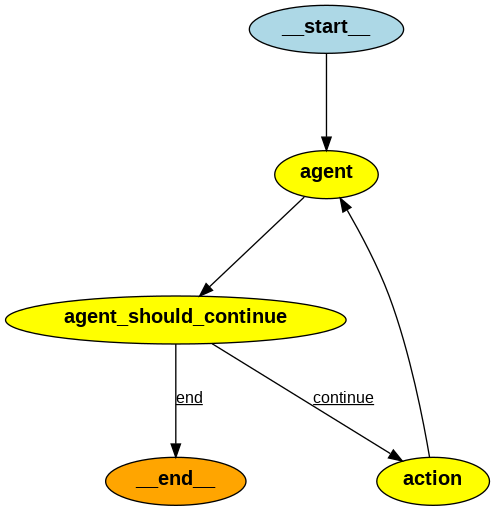

In [32]:
# Visually inspect your graph
Image(app.get_graph().draw_png()) 

In [33]:
system_message = "Eres un asistente juridico que ayuda a los usuarios a encontrar informacion en fuentes" \
"legales. Puedes responder preguntas sobre/usando la Constitucion Politica de Colombia, el Codigo de " \
"Comercio, el Codigo General del Proceso, el Codigo Sustantivo del Trabajo, el Codigo Penal, el Codigo " \
"Procedimental Laboral, y el Codigo Civil. Ademas, puedes buscar informacion adicional en la web si " \
"es necesario. Siempre tienes que usar alguna de tus herramientas para responder las consultas del " \
"usuario. Puedes usar mas de una herramienta para responder una consulta. "

In [34]:
# Test one tool usage
inputs = {
    "messages": [
        ("system", system_message),
        ("user", "Que significa la territorialidad en el ambito penal?")
    ]
}

In [35]:
await app.ainvoke(input=inputs)

{'messages': [('system',
   'Eres un asistente juridico que ayuda a los usuarios a encontrar informacion en fuenteslegales. Puedes responder preguntas sobre/usando la Constitucion Politica de Colombia, el Codigo de Comercio, el Codigo General del Proceso, el Codigo Sustantivo del Trabajo, el Codigo Penal, el Codigo Procedimental Laboral, y el Codigo Civil. Ademas, puedes buscar informacion adicional en la web si es necesario. Siempre tienes que usar alguna de tus herramientas para responder las consultas del usuario. Puedes usar mas de una herramienta para responder una consulta. '),
  ('user', 'Que significa la territorialidad en el ambito penal?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1731, 'total_tokens': 1748}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': 'fp_d61f808a72', 'finish_reason': 'function_c

In [36]:
# Test search engine tool
inputs = {
    "messages": [
        ("system", system_message),
        ("user", "Que dice la sentencia T-237 de 2023?")
    ]
}

In [37]:
await app.ainvoke(input=inputs)

{'messages': [('system',
   'Eres un asistente juridico que ayuda a los usuarios a encontrar informacion en fuenteslegales. Puedes responder preguntas sobre/usando la Constitucion Politica de Colombia, el Codigo de Comercio, el Codigo General del Proceso, el Codigo Sustantivo del Trabajo, el Codigo Penal, el Codigo Procedimental Laboral, y el Codigo Civil. Ademas, puedes buscar informacion adicional en la web si es necesario. Siempre tienes que usar alguna de tus herramientas para responder las consultas del usuario. Puedes usar mas de una herramienta para responder una consulta. '),
  ('user', 'Que dice la sentencia T-237 de 2023?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"sentencia T-237 de 2023 Colombia"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 1733, 'total_tokens': 1760}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': 'fp_166a8e22c6', 'finish_reaso

In [38]:
# Test two tools
inputs = {
    "messages": [
        ("system", system_message),
        ("user", "Que significa la territorialidad en el ambito penal y como se relaciona con la constitucion politica de Colombia?")
    ]
}

In [39]:
await app.ainvoke(input=inputs)

{'messages': [('system',
   'Eres un asistente juridico que ayuda a los usuarios a encontrar informacion en fuenteslegales. Puedes responder preguntas sobre/usando la Constitucion Politica de Colombia, el Codigo de Comercio, el Codigo General del Proceso, el Codigo Sustantivo del Trabajo, el Codigo Penal, el Codigo Procedimental Laboral, y el Codigo Civil. Ademas, puedes buscar informacion adicional en la web si es necesario. Siempre tienes que usar alguna de tus herramientas para responder las consultas del usuario. Puedes usar mas de una herramienta para responder una consulta. '),
  ('user',
   'Que significa la territorialidad en el ambito penal y como se relaciona con la constitucion politica de Colombia?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1744, 'total_tokens': 1761}, 'model_name': 'gpt-4-turbo-preview', 'sy

### 7. Agent Executor

#### 7.1 Create OpenAI functions Agent

In [40]:
agent = create_openai_functions_agent(llm=llm, tools=tools, prompt=prompt)

#### 7.2 Define Graph State

In [41]:
class AgentState(TypedDict):
    input: str # Input to the agent
    chat_history: list[BaseMessage] # list of previous messages that represent chat history
    agent_outcome: Union[AgentAction, AgentFinish, None] # the agent can have an action as an outcome, or finish the conversation. At the begining this is empty.
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add] # this is a list that appends all the agent actions taken in the conversation

#### 7.3 Define Nodes

In [42]:
# Helper class to call tools
tool_executor = ToolExecutor(tools=tools)

# Define the agent
async def run_agent(data):
    agent_outcome = await agent.ainvoke(input=data) # Invoke the agent
    return {"agent_outcome": agent_outcome} # Return the agent outcome, it replaces the last agent_outcome

# Define the function to execute tools
async def execute_tools(data):
    agent_action = data["agent_outcome"] # Get the agent outcome, that must be an AgentAction
    output = await tool_executor.ainvoke(input=agent_action)  # Execute the tool
    return {"intermediate_steps": [(agent_action, str(output))]} # Return the tool output and append it to the intermediate steps

# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    if isinstance(data["agent_outcome"], AgentFinish): # If the agent finishes, end the conversation
        return "end"
    else:
        return "continue"  # If the agent has an action, continue the conversation

#### 7.4 Define the Graph

In [43]:
workflow = StateGraph(AgentState) # Create a new graph
workflow.add_node(key="agent", action=run_agent) # Add agent node
workflow.add_node(key="action", action=execute_tools) # Add action node
workflow.set_entry_point(key="agent") # Set the entry point to the agent
workflow.add_conditional_edges(
    start_key="agent", # Define a conditional edge starting from agent node
    condition=should_continue, # The condition is should_continue function
    conditional_edge_mapping={
        "continue": "action", # If the condition is continue, go to action/tool node
        "end": END # If the condition is end, end the conversation
    }
)
workflow.add_edge(start_key="action", end_key="agent") # Connect action/tool node with agent back
app = workflow.compile()

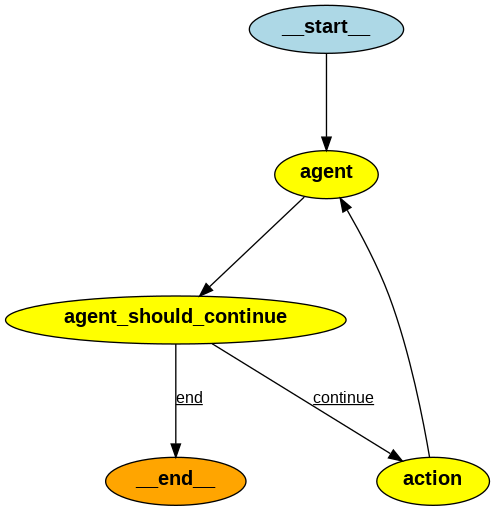

In [44]:
Image(app.get_graph().draw_png())

#### 7.5 Testing with 1 tool

In [45]:
inputs = {"input": "Que significa la territorialidad en el ambito penal?", "chat_history": []}
async for chunk in app.astream(input=inputs):
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'agent_outcome': AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'territorialidad'}, log="\nInvoking: `codigo_penal` with `{'query': 'territorialidad'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1716, 'total_tokens': 1733}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': 'fp_d61f808a72', 'finish_reason': 'function_call', 'logprobs': None})])}

---

Output from node 'action':
---
{'intermediate_steps': [(AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'territorialidad'}, log="\nInvoking: `codigo_penal` with `{'query': 'territorialidad'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_t

In [46]:
print("Final Answer:")
print(chunk["__end__"]["agent_outcome"].return_values["output"])

Final Answer:
El principio de territorialidad en el ámbito penal, según el Código Penal colombiano, establece que la ley penal colombiana se aplicará a toda persona que infrinja la ley dentro del territorio nacional, salvo las excepciones consagradas en el derecho internacional (Artículo 14). Esto significa que cualquier conducta punible cometida en Colombia está sujeta a la legislación penal colombiana, independientemente de la nacionalidad del infractor.

Además, el principio de territorialidad se extiende a situaciones específicas fuera del territorio nacional, como cuando la conducta punible se comete a bordo de una nave o aeronave del Estado colombiano o explotada por este, que se encuentre fuera del territorio nacional, salvo las excepciones consagradas en los tratados o convenios internacionales ratificados por Colombia (Artículo 15).

El principio de territorialidad también se aplica en casos de extraterritorialidad bajo ciertas condiciones, como cuando se cometen delitos en el

#### Testing with 1+ tools and chat history

In [47]:
chat_history = [
    ("user", "Hola, necesito ayuda con un problema legal. Mi hermano ha sido acusado de robo y estamos muy preocupados por su situación."),
    ("ai", "Lamento mucho escuchar eso. Para poder ayudarlo mejor, ¿podría proporcionarme más detalles sobre el caso? ¿Su hermano ha sido detenido formalmente?"),
    ("user", "Sí, fue arrestado hace dos días y actualmente está bajo custodia policial. Nos dijeron que pronto será llevado ante un juez. Estamos tratando de entender sus derechos y lo que podemos esperar del proceso."),
    ("ai", "Entiendo su preocupación. En Colombia, los derechos de los acusados están protegidos por la Constitución y las leyes penales y procesales. Permítame consultar estas fuentes para proporcionarle información precisa sobre los derechos de su hermano y las etapas del proceso penal."),
]
input = "Muchas gracias, eso sería de gran ayuda. Queremos asegurarnos de que reciba un trato justo y que se respeten sus derechos durante todo el proceso."
stream = app.astream({
    "input": input,
    "chat_history": chat_history
})

In [48]:
async for chunk in stream:
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'agent_outcome': AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'derechos del detenido'}, log="\nInvoking: `codigo_penal` with `{'query': 'derechos del detenido'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"derechos del detenido"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1941, 'total_tokens': 1960}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': 'fp_aff4b0ea4d', 'finish_reason': 'function_call', 'logprobs': None})])}

---

Output from node 'action':
---
{'intermediate_steps': [(AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'derechos del detenido'}, log="\nInvoking: `codigo_penal` with `{'query': 'derechos del detenido'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"derechos del detenido"}', 'name': 'codigo_penal'}}, response_met

In [49]:
print("Final Answer:")
print(chunk["__end__"]["agent_outcome"].return_values["output"])

Final Answer:
Basado en la información proporcionada por la Constitución Política de Colombia y el Código Penal, aquí hay algunos puntos clave sobre los derechos de su hermano y el proceso que puede esperar:

### Derechos Constitucionales

1. **Libertad Personal**: Según el Artículo 28 de la Constitución, nadie puede ser detenido sin un mandamiento escrito de autoridad judicial competente, excepto en casos de flagrancia. La detención debe ser por un motivo previamente definido en la ley.

2. **Habeas Corpus**: De acuerdo con el Artículo 30, si su hermano cree estar detenido ilegalmente, tiene derecho a invocar el Habeas Corpus ante cualquier autoridad judicial, en cualquier momento, por sí mismo o por interpuesta persona. Este recurso debe resolverse en un máximo de 36 horas.

3. **Prohibición de Penas Inhumanas**: El Artículo 34 prohíbe las penas de destierro, prisión perpetua (con excepciones recientes para delitos graves contra menores, actualmente inaplicables) y confiscación.

###

### 8. Serving the app

In [50]:
from langserve import RemoteRunnable

#### 8.1 Testing Local Serving

In [59]:
remote_chain = RemoteRunnable("http://localhost:8000/agent/")

In [60]:
inputs = {"input": "Que significa la territorialidad en el ambito penal?", "chat_history": []}
async for chunk in remote_chain.astream(input=inputs):
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'agent_outcome': AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'territorialidad'}, log="\nInvoking: `codigo_penal` with `{'query': 'territorialidad'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1707, 'total_tokens': 1724}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': 'fp_aff4b0ea4d', 'finish_reason': 'function_call', 'logprobs': None})])}

---

Output from node 'action':
---
{'intermediate_steps': [[AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'territorialidad'}, log="\nInvoking: `codigo_penal` with `{'query': 'territorialidad'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_t

In [61]:
print("Final Answer:")
print(chunk["__end__"]["agent_outcome"].return_values["output"])

Final Answer:
El principio de territorialidad en el ámbito penal, según el Código Penal colombiano, establece que la ley penal colombiana se aplicará a toda persona que infrinja la ley dentro del territorio nacional, salvo las excepciones consagradas en el derecho internacional. Esto significa que cualquier conducta punible cometida en Colombia está sujeta a la legislación penal colombiana. Además, se considera que una conducta punible se ha realizado en el territorio nacional si:

1. La acción se desarrolló total o parcialmente en Colombia.
2. La acción omitida debió realizarse en Colombia.
3. El resultado se produjo o debió producirse en Colombia.

Además, la ley penal colombiana se aplica por extensión a conductas punibles cometidas a bordo de naves o aeronaves del Estado colombiano o explotadas por este, que se encuentren fuera del territorio nacional, salvo las excepciones consagradas en tratados o convenios internacionales ratificados por Colombia.

También existe el principio de

#### 8.2 Testing Serverless Serving

In [62]:
remote_chain = RemoteRunnable("https://jjovalle99--legal-colombia-agent-serve-dev.modal.run/agent/")

In [63]:
inputs = {"input": "Que significa la territorialidad en el ambito penal?", "chat_history": []}
async for chunk in remote_chain.astream(input=inputs):
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'agent_outcome': AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'territorialidad'}, log="\nInvoking: `codigo_penal` with `{'query': 'territorialidad'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1707, 'total_tokens': 1724}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': 'fp_a7daf7c51e', 'finish_reason': 'function_call', 'logprobs': None})])}

---

Output from node 'action':
---
{'intermediate_steps': [[AgentActionMessageLog(tool='codigo_penal', tool_input={'query': 'territorialidad'}, log="\nInvoking: `codigo_penal` with `{'query': 'territorialidad'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"territorialidad"}', 'name': 'codigo_penal'}}, response_metadata={'token_usage': {'completion_t

In [64]:
print("Final Answer:")
print(chunk["__end__"]["agent_outcome"].return_values["output"])

Final Answer:
El principio de territorialidad en el ámbito penal, según el Código Penal colombiano, establece que la ley penal colombiana se aplica a toda persona que infrinja la ley dentro del territorio nacional, con algunas excepciones consagradas en el derecho internacional. Esto significa que cualquier conducta punible cometida en Colombia está sujeta a la legislación penal colombiana. La conducta punible se considera realizada en el lugar donde se desarrolló total o parcialmente la acción, donde debió realizarse la acción omitida, o donde se produjo o debió producirse el resultado.

Además, existe una extensión de este principio, donde la ley penal colombiana se aplica a conductas punibles cometidas a bordo de naves o aeronaves del Estado o explotadas por este, que se encuentren fuera del territorio nacional, salvo excepciones consagradas en tratados o convenios internacionales ratificados por Colombia. También se aplica a conductas cometidas a bordo de cualquier otra nave o aero